In [4]:
import re

In [3]:
# prompt: upload this from kaggle:"https://www.kaggle.com/datasets/rtatman/blog-authorship-corpus?resource=download"

!kaggle datasets download -d rtatman/blog-authorship-corpus


Dataset URL: https://www.kaggle.com/datasets/rtatman/blog-authorship-corpus
License(s): other
blog-authorship-corpus.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
# prompt: save the data into a df variable (the data is a zip)

!unzip blog-authorship-corpus.zip
import pandas as pd
data = pd.read_csv('blogtext.csv')
data.head()

Archive:  blog-authorship-corpus.zip
replace blogtext.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: blogtext.csv            y



,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


In [6]:
data.isna().any()

id        False
gender    False
age       False
topic     False
sign      False
date      False
text      False
dtype: bool

In [7]:
data.shape

(681284, 7)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681284 entries, 0 to 681283
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      681284 non-null  int64 
 1   gender  681284 non-null  object
 2   age     681284 non-null  int64 
 3   topic   681284 non-null  object
 4   sign    681284 non-null  object
 5   date    681284 non-null  object
 6   text    681284 non-null  object
dtypes: int64(2), object(5)
memory usage: 36.4+ MB


In [19]:
data['clean_data']=data['text'].apply(lambda x: re.sub(r'[^A-Za-z]+',' ',x))
data['clean_data']=data['clean_data'].apply(lambda x: x.lower())
data['clean_data']=data['clean_data'].apply(lambda x: x.strip())

In [20]:
# prompt: the data is to big, I want you to split the data to small part to use this for testing my models, show me a sample of the data with 1000 samples

sample_data = data.sample(n=1000)
print(sample_data.head())


             id  gender age       topic         sign             date  \
637423  4209520    male  26  Technology       Cancer   12,August,2004   
286056  1919658  female  27         Law       Cancer     20,June,2004   
60588    700788    male  23      indUnk  Sagittarius  17,January,2004   
550449   219407    male  34         Law     Aquarius     26,July,2004   
424575  3954023  female  36        Arts     Aquarius   16,August,2004   

                                                     text  \
637423         Well I have goined the masses and have ...   
286056                This Old House   In an effort to...   
60588               Rox said:   As for Dream Interpret...   
550449                     urlLink What Famous Leader ...   
424575           '... Tremendous breakthrough', says A...   

                                               clean_data  
637423  well i have goined the masses and have started...  
286056  this old house in an effort to advance as a pe...  
60588   rox sa

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = tfidf.fit_transform(sample_data['clean_data'])

# Create user profiles by averaging TF-IDF vectors for each user
user_profiles = {}
for user_id in sample_data['id'].unique():
    user_posts = sample_data[sample_data['id'] == user_id]['clean_data']
    user_tfidf = tfidf.transform(user_posts)
    user_profile = user_tfidf.mean(axis=0)
    user_profiles[user_id] = user_profile

# Convert user profiles to a matrix (removing the unnecessary .toarray() call)
user_profile_matrix = np.array([user_profiles[uid][0] for uid in user_profiles])

In [23]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
nltk.download('punkt')

# Prepare documents
tagged_data = [TaggedDocument(words=word_tokenize(text.lower()), tags=[str(i)]) for i, text in enumerate(sample_data['clean_data'])]

# Train Doc2Vec model
model = Doc2Vec(vector_size=100, window=2, min_count=1, workers=4, epochs=100)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# Create user profiles using Doc2Vec
user_profiles_doc2vec = {}
for user_id in sample_data['id'].unique():
    user_posts = sample_data[sample_data['id'] == user_id]['clean_data']
    user_vectors = [model.infer_vector(word_tokenize(post.lower())) for post in user_posts]
    user_profile = np.mean(user_vectors, axis=0)
    user_profiles_doc2vec[user_id] = user_profile

# Calculate similarity using Doc2Vec embeddings
doc2vec_similarity_matrix = cosine_similarity(list(user_profiles_doc2vec.values()))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [24]:
doc2vec_similarity_matrix

array([[1.0000002 , 0.2715098 , 0.4129295 , ..., 0.16782366, 0.22708559,
        0.14878783],
       [0.2715098 , 1.0000001 , 0.21740378, ..., 0.23290044, 0.23568268,
        0.18071851],
       [0.4129295 , 0.21740378, 1.        , ..., 0.35432577, 0.34959182,
        0.506078  ],
       ...,
       [0.16782366, 0.23290044, 0.35432577, ..., 0.99999976, 0.29437503,
        0.24045876],
       [0.22708559, 0.23568268, 0.34959182, ..., 0.29437503, 1.        ,
        0.26160362],
       [0.14878783, 0.18071851, 0.506078  , ..., 0.24045876, 0.26160362,
        0.9999999 ]], dtype=float32)

In [26]:
def recommend_users(user_id, n=5):
    user_index = list(user_profiles.keys()).index(user_id)
    similarities = doc2vec_similarity_matrix[user_index]
    similar_indices = similarities.argsort()[-n-1:-1][::-1]
    similar_users = [list(user_profiles.keys())[i] for i in similar_indices]
    return [(user, similarities[i]) for i, user in zip(similar_indices, similar_users) if user != user_id]

# Example usage
example_user = sample_data['id'].iloc[0]
recommendations = recommend_users(example_user)
print(f"Top 5 recommended users for user {example_user}:")
for user, similarity in recommendations:
    print(f"User {user}: Similarity {similarity:.2f}")



Top 5 recommended users for user 4209520:
User 3414881: Similarity 0.52
User 3498701: Similarity 0.50
User 2432036: Similarity 0.47
User 522409: Similarity 0.46
User 3610040: Similarity 0.46


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


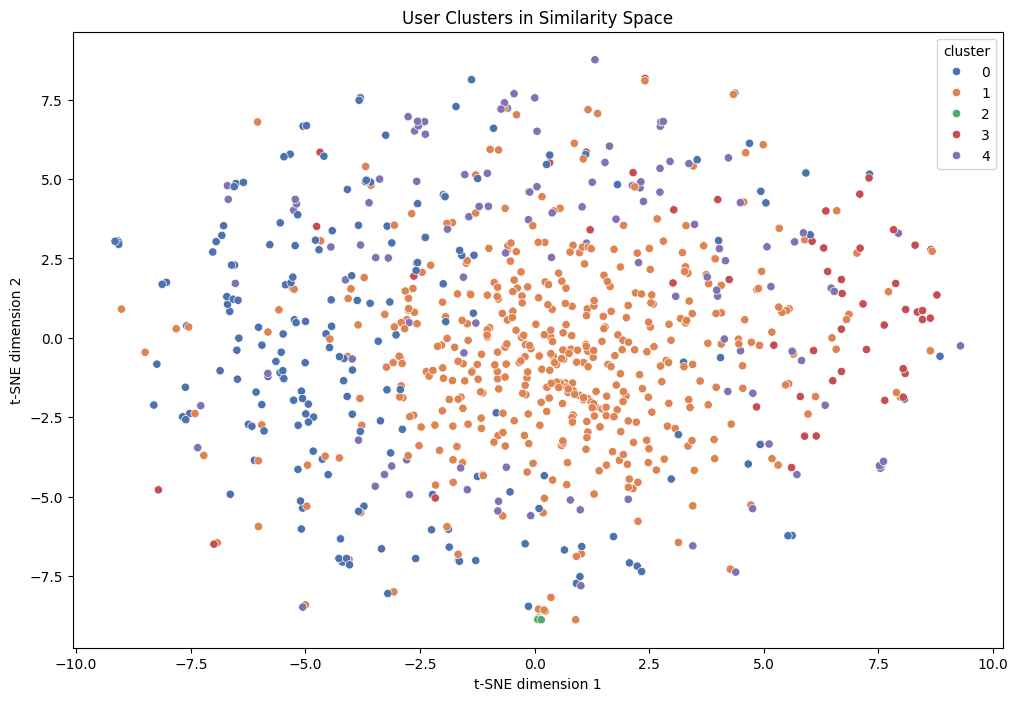

In [35]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure user_profile_matrix is 2D
if user_profile_matrix.ndim > 2:
    user_profile_matrix = np.array([profile.mean(axis=0).A[0] if sparse.issparse(profile)
                                    else profile.mean(axis=0)
                                    for profile in user_profile_matrix])

# Perform K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(user_profile_matrix)

# Perform t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
user_profile_2d = tsne.fit_transform(user_profile_matrix)

# Create a DataFrame with the t-SNE results and cluster labels
viz_df = pd.DataFrame({
    'x': user_profile_2d[:, 0],
    'y': user_profile_2d[:, 1],
    'cluster': cluster_labels,
    'user_id': list(user_profiles.keys())
})

# Visualize clusters in the t-SNE space
plt.figure(figsize=(12, 8))
sns.scatterplot(data=viz_df, x='x', y='y', hue='cluster', palette='deep', legend='full')
plt.title('User Clusters in Similarity Space')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')

# # Optionally, annotate points with user IDs
# for i, row in viz_df.iterrows():
#     plt.annotate(row['user_id'], (row['x'], row['y']), xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)

plt.show()


In [36]:
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to get BERT embeddings for a text
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Create user profiles using BERT embeddings
user_profiles_bert = {}
for user_id in sample_data['id'].unique():
    user_posts = sample_data[sample_data['id'] == user_id]['clean_data']
    user_vectors = [get_bert_embedding(post) for post in user_posts]
    user_profile = np.mean(user_vectors, axis=0)
    user_profiles_bert[user_id] = user_profile

# Calculate similarity using BERT embeddings
bert_similarity_matrix = cosine_similarity(list(user_profiles_bert.values()))

bert_similarity_matrix

array([[0.9999999 , 0.9409211 , 0.9000963 , ..., 0.8683525 , 0.8682759 ,
        0.6101078 ],
       [0.9409211 , 0.99999994, 0.86567646, ..., 0.85909975, 0.87955856,
        0.5893808 ],
       [0.9000963 , 0.86567646, 1.0000005 , ..., 0.84682935, 0.85499287,
        0.6260745 ],
       ...,
       [0.8683525 , 0.85909975, 0.84682935, ..., 1.0000004 , 0.85085976,
        0.56173325],
       [0.8682759 , 0.87955856, 0.85499287, ..., 0.85085976, 0.99999976,
        0.51795995],
       [0.6101078 , 0.5893808 , 0.6260745 , ..., 0.56173325, 0.51795995,
        1.0000004 ]], dtype=float32)

In [37]:
def recommend_users_bert(user_id, n=5):
    user_index = list(user_profiles.keys()).index(user_id)
    similarities = bert_similarity_matrix[user_index]
    similar_indices = similarities.argsort()[-n-1:-1][::-1]
    similar_users = [list(user_profiles.keys())[i] for i in similar_indices]
    return [(user, similarities[i]) for i, user in zip(similar_indices, similar_users) if user != user_id]

# Example usage
example_user = sample_data['id'].iloc[0]
recommendations = recommend_users(example_user)
print(f"Top 5 recommended users for user {example_user}:")
for user, similarity in recommendations:
    print(f"User {user}: Similarity {similarity:.2f}")


Top 5 recommended users for user 4209520:
User 3414881: Similarity 0.52
User 3498701: Similarity 0.50
User 2432036: Similarity 0.47
User 522409: Similarity 0.46
User 3610040: Similarity 0.46


In [40]:
from textblob import TextBlob

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Add sentiment score to the dataframe
sample_data['sentiment'] = sample_data['clean_data'].apply(get_sentiment)

# Calculate average sentiment per user
user_sentiment = sample_data.groupby('id')['sentiment'].mean()



In [41]:
user_sentiment

id
5114       0.150000
8173       0.072762
15365      0.082407
17944      0.000000
24336     -0.171111
             ...   
4282943   -0.026136
4287321    0.000000
4293279    0.033963
4301895    0.600000
4312374    0.007692
Name: sentiment, Length: 829, dtype: float64